# SVM Tuning (Fingerprints)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)

from sklearn.svm import SVC
import shap
import optuna

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Molecule, Fingerprints and Outlier Functions


In [2]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_morgan_fingerprint(mol, n_bits=2048, radius=2):
    # Calculate Morgan fingerprint
    feats = {}
    if mol is None:
        return feats

    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=radius, nBits=n_bits
    )
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)

    for i, v in enumerate(arr):
        feats[f"Morgan{n_bits}_{i}"] = int(v)

    return feats

## Dataset Processing


In [3]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 1.00
# Correlation threshold
CORRELATION_THRESHOLD = 1.00

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build Morgan fingerprints
fingerprint_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        fingerprint_rows.append({})
        continue

    fingerprint_rows.append(calculate_morgan_fingerprint(molecule))

# DataFrame with fingerprints
fingerprint_data_all = pd.DataFrame(fingerprint_rows).fillna(0).astype(int)

# Attach to original data + status
output = pd.concat(
    [dataset.reset_index(drop=True), fingerprint_data_all.reset_index(drop=True)],
    axis=1,
)
output["MoleculeStatus"] = state_molecules

with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Fingerprints")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Select only successful molecules
molecules_right = [mol is not None for mol in molecules]

if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
fingerprint_ok = fingerprint_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Features = Morgan bits directly
X_full = fingerprint_ok.copy()

# (optional safety: replace inf, though shouldn't appear for bits)
X_full = X_full.replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN (shouldn't happen, but safe)
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Drop constant / almost-constant bits based on train
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Drop highly correlated bits (on train only, apply to both)
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Save
X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerator
[09:28:01] DEPRECATION WARNING: please use MorganGenerat

Full - Rows: 162/Columns: 2061
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  Morgan2048_0  Morgan2048_1  Morgan2048_2  Morgan2048_3  Morgan2048_4  Morgan2048_5  Morgan2048_6  Morgan2048_7  Morgan2048_8  Morgan2048_9  Morgan2048_10  Morgan2048_11  Morgan2048_12  Morgan2048_13  Morgan2048_14  Morgan2048_15  Morgan2048_16  Morgan2048_17  Morgan2048_18  Morgan2048_19  Morgan2048_20  Morgan2048_21  Morgan2048_22  Morgan2048_23  Morgan2048_24  Morgan2048_25  Morgan2048_26  Morgan2048_27  Morgan2048_28  Morgan2048_29  Morgan2048_30  Morgan2048_31  Morgan2048_32  Morgan2048_33  Morgan2048_34  Morgan2048_35  Morgan2048_36  Morgan2048_37  Morgan2048_38  Morgan2048_39  Morgan2048_40  Morgan2048_

## Base Model Train


In [4]:
# SVM pipeline: scale features + RBF-kernel SVM with calibrated probabilities
base_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance (SVM):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance (SVM):
Accuracy:  0.6667
Precision: 0.7333
Recall:    0.6111
F1 score:  0.6667
ROC AUC:   0.7889

Classification report:
              precision    recall  f1-score   support

           0      0.611     0.733     0.667        15
           1      0.733     0.611     0.667        18

    accuracy                          0.667        33
   macro avg      0.672     0.672     0.667        33
weighted avg      0.678     0.667     0.667        33



## Feature Selection


PermutationExplainer explainer: 130it [04:06,  1.96s/it]                         
/tmp/ipykernel_48750/2115275593.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


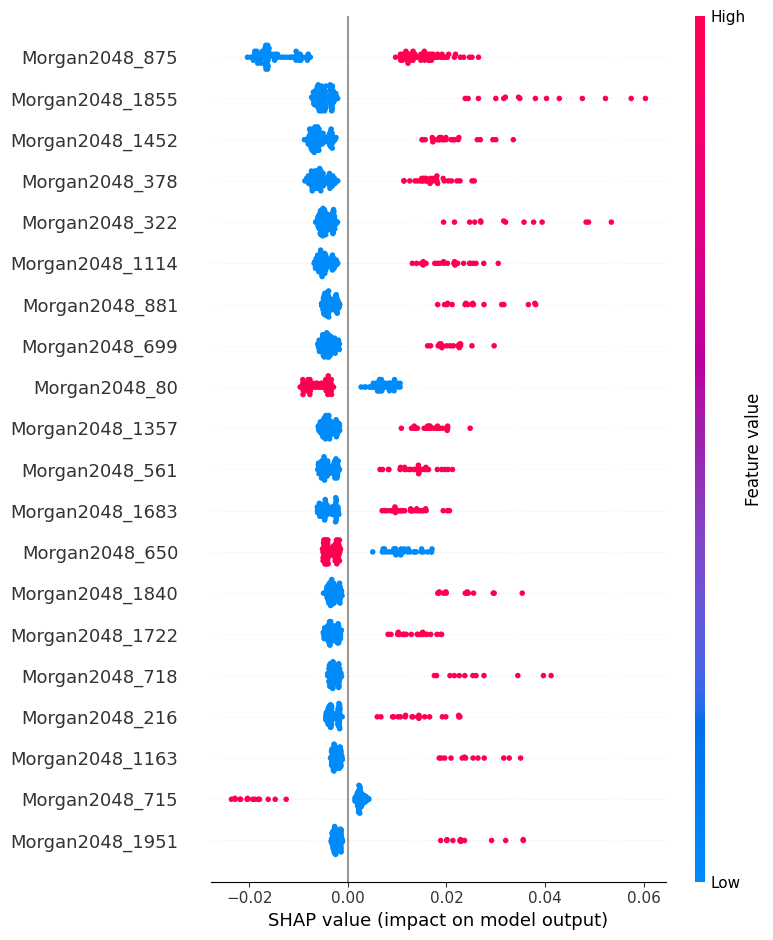


Top 10 SHAP features:
Morgan2048_875     0.015267
Morgan2048_1855    0.008809
Morgan2048_1452    0.008809
Morgan2048_378     0.008711
Morgan2048_322     0.007596
Morgan2048_1114    0.007592
Morgan2048_881     0.006682
Morgan2048_699     0.006625
Morgan2048_80      0.006602
Morgan2048_1357    0.006330

Top 10 K-Best features:
Morgan2048_1840    15.035941
Morgan2048_699     13.848304
Morgan2048_1380    11.987688
Morgan2048_1873    11.655298
Morgan2048_1357    11.319478
Morgan2048_322     10.422472
Morgan2048_1452    10.373731
Morgan2048_624     10.011825
Morgan2048_453     10.011825
Morgan2048_525      9.248973

Top 10 Lasso features:
Morgan2048_322     1.952070
Morgan2048_881     1.431631
Morgan2048_1535    1.259704
Morgan2048_1855    1.193446
Morgan2048_699     1.108164
Morgan2048_1970    1.063528
Morgan2048_715     1.033292
Morgan2048_2033    0.985719
Morgan2048_1457    0.977695
Morgan2048_1840    0.853291


In [7]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(
    ascending=False
)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k="all")
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(penalty="l1", C=1.0, solver="liblinear", max_iter=5000)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

# Print best features for each method
print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())
print("\nTop 10 K-Best features:")
print(kbest_features.head(10).to_string())
print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())

## SHAP Features



CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.658462  0.676163    0.667125
1      6     0.689538  0.696488    0.735852
2      7     0.705538  0.727057    0.720421
3      8     0.759385  0.777509    0.796429
4      9     0.751692  0.764098    0.800092

Best number of features by CV F1: 132
Top_N          132.000000
CV_Accuracy      0.791385
CV_F1            0.802525
CV_ROC_AUC       0.841026
Name: 127, dtype: float64


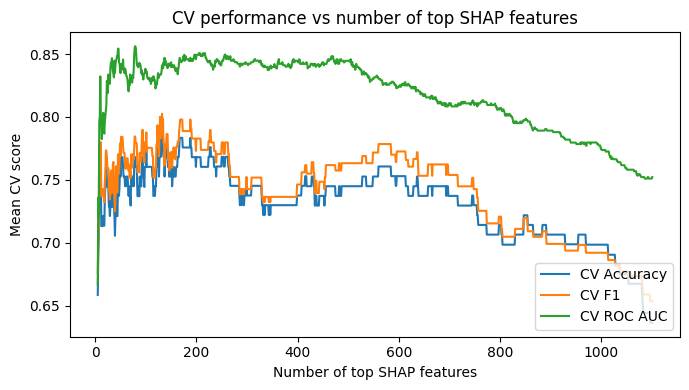

In [8]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(shap_features) + 1):
    top_feats = shap_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_shap = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top SHAP features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top SHAP features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## KBEST Features



CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.659692  0.579976    0.660668
1      6     0.721231  0.682528    0.749038
2      7     0.752308  0.745897    0.779579
3      8     0.744308  0.731352    0.796520
4      9     0.728615  0.710000    0.800687

Best number of features by CV F1: 342
Top_N          342.000000
CV_Accuracy      0.821846
CV_F1            0.817692
CV_ROC_AUC       0.873810
Name: 337, dtype: float64


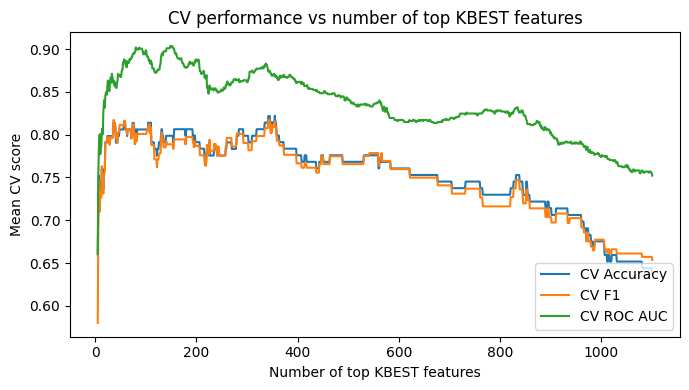

In [9]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1):
    top_feats = kbest_features.head(n).index

    # model = xgb.XGBClassifier(
    #     objective="binary:logistic", eval_metric=["logloss", "auc"], random_state=42
    # )

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features



CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.790769  0.787656    0.791987
1      6     0.790769  0.787656    0.768132
2      7     0.783077  0.780989    0.758700
3      8     0.790769  0.787656    0.805952
4      9     0.790769  0.787656    0.825595

Best number of features by CV F1: 27
Top_N          27.000000
CV_Accuracy     0.845231
CV_F1           0.856201
CV_ROC_AUC      0.908104
Name: 22, dtype: float64


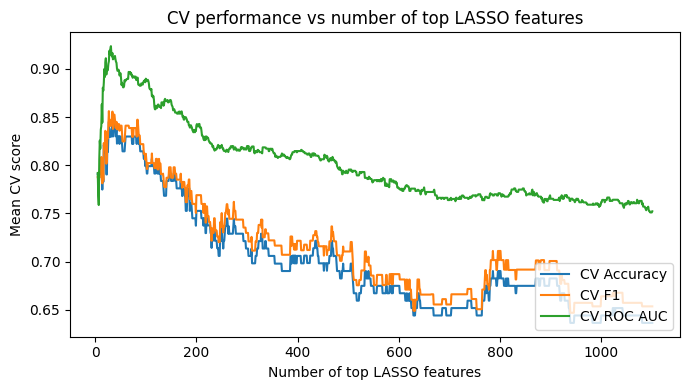

In [10]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1):
    top_feats = lasso_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features


In [11]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.7273
Precision: 0.8000
Recall:    0.6667
F1 score:  0.7273
ROC AUC:   0.7370


## Model KBEST Features


In [12]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.5758
Precision: 0.6667
Recall:    0.4444
F1 score:  0.5333
ROC AUC:   0.6926


## Model LASSO Features


In [13]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.5152
Precision: 0.5714
Recall:    0.4444
F1 score:  0.5000
ROC AUC:   0.6130


## Model SHAP Features Tuning


In [14]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 1. Best value: 0.835806:  18%|█▊        | 37/200 [00:01<00:04, 34.02it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 1. Best value: 0.835806:  20%|█▉        | 39/200 [00:01<00:04, 34.00it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-pac


Best trial:
  Value: 0.8482600732600734
  Params:
    kernel: rbf
    C: 1.4023121251308244
    class_weight: balanced
    shrinking: False
    tol: 1.2942737592758744e-05
    max_iter: 1000
    gamma_mode: scale

Final Optuna model (SHAP):
Accuracy:  0.6970
Precision: 0.7857
Recall:    0.6111
F1 score:  0.6875
ROC AUC:   0.7370


## Model KBEST Features Tuning


In [15]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # Hyperparameter search space
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        scoring="f1",
        # scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 37. Best value: 0.840462:  28%|██▊       | 55/200 [00:01<00:04, 30.64it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 37. Best value: 0.840462: 100%|██████████| 200/200 [00:06<00:00, 30.28it/s]


Best trial:
  Value: 0.8404622963243653
  Params:
    kernel: linear
    C: 0.8900241072106159
    class_weight: None
    shrinking: True
    tol: 0.00010416903978815251
    max_iter: 2000
    gamma_mode: float
    gamma: 2.02713238238768

Final Optuna model (KBEST):
Accuracy:  0.6061
Precision: 0.6923
Recall:    0.5000
F1 score:  0.5806
ROC AUC:   0.5481


## Model LASSO Features Tuning


In [16]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 5. Best value: 0.922024:   6%|▌         | 12/200 [00:00<00:03, 47.05it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 15. Best value: 0.928984:  16%|█▌        | 31/200 [00:00<00:04, 37.95it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 42. Best value: 0.932555:  60%|██████    | 121/200 [00:03<00:02, 36.83it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



Best trial:
  Value: 0.9325549450549449
  Params:
    kernel: linear
    C: 0.530461565688658
    class_weight: None
    shrinking: False
    tol: 0.0006595690201803414
    max_iter: 2000
    gamma_mode: auto

Final Optuna model (LASSO):
Accuracy:  0.6364
Precision: 0.7143
Recall:    0.5556
F1 score:  0.6250
ROC AUC:   0.6500


## Model SHAP Features Tuning (Randomized Search CV)


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



=== Testing top 5 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.17426333860096507), 'degree': 2, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(58.05225516094895)}
Accuracy: 0.667 | ROC-AUC: 0.607

=== Testing top 6 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.10353218432956626), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': None, 'C': np.float64(4.150404757850472)}
Accuracy: 0.576 | ROC-AUC: 0.669

=== Testing top 7 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0032374575428176433), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(1.5702901247293775), 'degree': 3, 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.010595601792776159)}
Accuracy: 0.606 | ROC-AUC: 0.676

=== Testing top 8 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.10353218432956626), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': None, 'C': np.float64(4.150404757850472)}
Accuracy: 0.606 | ROC-AUC: 0.704

=== Testing top 9 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(8.286427728546843e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0690551352016233), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(28.99422853882875)}
Accuracy: 0.576 | ROC-AUC: 0.641

=== Testing top 10 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.02736439997074672), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(4.150404757850472)}
Accuracy: 0.515 | ROC-AUC: 0.606

=== Testing top 11 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.02899422853882878), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(10.96985797892384)}
Accuracy: 0.545 | ROC-AUC: 0.659

=== Testing top 12 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.000339322177189533), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(3.1440354715915), 'degree': 2, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(5.872786613189477)}
Accuracy: 0.606 | ROC-AUC: 0.711

=== Testing top 13 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.02899422853882878), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(10.96985797892384)}
Accuracy: 0.576 | ROC-AUC: 0.637

=== Testing top 14 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0028660676169482502), 'degree': 3, 'coef0': np.float64(0.8), 'class_weight': None, 'C': np.float64(14.48118227674533)}
Accuracy: 0.606 | ROC-AUC: 0.689

=== Testing top 15 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.576 | ROC-AUC: 0.693

=== Testing top 16 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.515 | ROC-AUC: 0.669

=== Testing top 17 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0028660676169482502), 'degree': 3, 'coef0': np.float64(0.8), 'class_weight': None, 'C': np.float64(14.48118227674533)}
Accuracy: 0.606 | ROC-AUC: 0.680

=== Testing top 18 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.08703591361485166), 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(2.381685551976158)}
Accuracy: 0.606 | ROC-AUC: 0.648

=== Testing top 19 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.545 | ROC-AUC: 0.637

=== Testing top 20 features ===
Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.545 | ROC-AUC: 0.661

=== Testing top 21 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0028660676169482502), 'degree': 3, 'coef0': np.float64(0.8), 'class_weight': None, 'C': np.float64(14.48118227674533)}
Accuracy: 0.606 | ROC-AUC: 0.615

=== Testing top 22 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.545 | ROC-AUC: 0.637

=== Testing top 23 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.003727593720314938), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.0008504489341802677), 'degree': 5, 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(47.13753134116719)}
Accuracy: 0.545 | ROC-AUC: 0.363

=== Testing top 24 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.003727593720314938), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.0008504489341802677), 'degree': 5, 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(47.13753134116719)}
Accuracy: 0.545 | ROC-AUC: 0.359

=== Testing top 25 features ===
Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.626

=== Testing top 26 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.626

=== Testing top 27 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.622

=== Testing top 28 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.600

=== Testing top 29 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.615

=== Testing top 30 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.615

=== Testing top 31 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.622

=== Testing top 32 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.545 | ROC-AUC: 0.604

=== Testing top 33 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.545 | ROC-AUC: 0.611

=== Testing top 34 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.515 | ROC-AUC: 0.581

=== Testing top 35 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.576 | ROC-AUC: 0.578

=== Testing top 36 features ===
Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.576 | ROC-AUC: 0.593

=== Testing top 37 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.633

=== Testing top 38 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.633

=== Testing top 39 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.606 | ROC-AUC: 0.637

=== Testing top 40 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.644

=== Testing top 41 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.636 | ROC-AUC: 0.622

=== Testing top 42 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.606 | ROC-AUC: 0.630

=== Testing top 43 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0028660676169482502), 'degree': 3, 'coef0': np.float64(0.8), 'class_weight': None, 'C': np.float64(14.48118227674533)}
Accuracy: 0.636 | ROC-AUC: 0.670

=== Testing top 44 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.576 | ROC-AUC: 0.611

=== Testing top 45 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.576 | ROC-AUC: 0.589

=== Testing top 46 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.576 | ROC-AUC: 0.641

=== Testing top 47 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.0024094035602395267), 'degree': 3, 'coef0': np.float64(0.75), 'class_weight': None, 'C': np.float64(11.758495540521558)}
Accuracy: 0.667 | ROC-AUC: 0.685

=== Testing top 48 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.0024094035602395267), 'degree': 3, 'coef0': np.float64(0.75), 'class_weight': None, 'C': np.float64(11.758495540521558)}
Accuracy: 0.667 | ROC-AUC: 0.689

=== Testing top 49 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.606 | ROC-AUC: 0.596

=== Testing top 50 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.0024094035602395267), 'degree': 3, 'coef0': np.float64(0.75), 'class_weight': None, 'C': np.float64(11.758495540521558)}
Accuracy: 0.697 | ROC-AUC: 0.689

=== Testing top 51 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.606 | ROC-AUC: 0.589

=== Testing top 52 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.606 | ROC-AUC: 0.589

=== Testing top 53 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.0024094035602395267), 'degree': 3, 'coef0': np.float64(0.75), 'class_weight': None, 'C': np.float64(11.758495540521558)}
Accuracy: 0.697 | ROC-AUC: 0.678

=== Testing top 54 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.606 | ROC-AUC: 0.593


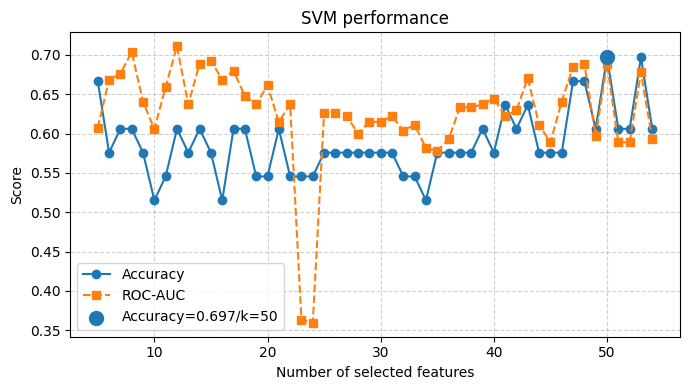


Accuracy = 0.697 | ROC-AUC = 0.689 | k = 50


In [17]:
ranking = shap_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)



=== Testing top 5 features ===
Best parameters: {'tol': np.float64(0.003727593720314938), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.0008504489341802677), 'degree': 5, 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(47.13753134116719)}
Accuracy: 0.545 | ROC-AUC: 0.339

=== Testing top 6 features ===
Best parameters: {'tol': np.float64(0.003727593720314938), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.0008504489341802677), 'degree': 5, 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(47.13753134116719)}
Accuracy: 0.545 | ROC-AUC: 0.354

=== Testing top 7 features ===
Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.636 | ROC-AUC: 0.633

=== Testing

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.515 | ROC-AUC: 0.633

=== Testing top 11 features ===
Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.515 | ROC-AUC: 0.646

=== Testing top 12 features ===
Best parameters: {'tol': np.float64(0.003727593720314938), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.0008504489341802677), 'degree': 5, 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(47.13753134116719)}
Accuracy: 0.545 | ROC-AUC: 0.346

=== Testing top 13 features ===
Best parameters: {'to

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.515 | ROC-AUC: 0.676

=== Testing top 15 features ===
Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.545 | ROC-AUC: 0.339

=== Testing top 16 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.515 | ROC-AUC: 0.631

=== Testing top 17 features ===
Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.515 | ROC-AUC: 0.630

=== Testing top 18 features ===
Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.13826221737646563), 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.545 | ROC-AUC: 0.394

=== Testing top 19 features ===
Best parameters: {'tol

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.485 | ROC-AUC: 0.604

=== Testing top 21 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.485 | ROC-AUC: 0.604

=== Testing top 22 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.485 | ROC-AUC: 0.570

=== Testing top 23 features ===
Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.485 | ROC-AUC: 0.570

=== Testing top 24 features ===
Best parameters: {'tol': np.float64(0.0018420699693267163), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.27682866303920667), 'degree': 2, 'coef0': np.float64(0.65), 'class_weight': None, 'C': np.float64(0.17027691722258995)}
Accuracy: 0.485 | ROC-AUC: 0.585

=== Testing top 25 features ===
Best parameters:

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.455 | ROC-AUC: 0.574

=== Testing top 28 features ===
Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.485 | ROC-AUC: 0.565

=== Testing top 29 features ===
Best parameters: {'tol': np.float64(0.01), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(4.448782831127585), 'degree': 2, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(0.0015167168884709225)}
Accuracy: 0.485 | ROC-AUC: 0.604

=== Testing top 30 features ===
Best parameters: {'tol

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.576 | ROC-AUC: 0.631

=== Testing top 37 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0018420699693267163), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.27682866303920667), 'degree': 2, 'coef0': np.float64(0.65), 'class_weight': None, 'C': np.float64(0.17027691722258995)}
Accuracy: 0.545 | ROC-AUC: 0.613

=== Testing top 38 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0018420699693267163), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.27682866303920667), 'degree': 2, 'coef0': np.float64(0.65), 'class_weight': None, 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.639

=== Testing top 39 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.01), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(4.448782831127585), 'degree': 2, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(0.0015167168884709225)}
Accuracy: 0.576 | ROC-AUC: 0.628

=== Testing top 40 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0018420699693267163), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.27682866303920667), 'degree': 2, 'coef0': np.float64(0.65), 'class_weight': None, 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.635

=== Testing top 41 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.576 | ROC-AUC: 0.646

=== Testing top 42 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0018420699693267163), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.27682866303920667), 'degree': 2, 'coef0': np.float64(0.65), 'class_weight': None, 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.646

=== Testing top 43 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0018420699693267163), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.27682866303920667), 'degree': 2, 'coef0': np.float64(0.65), 'class_weight': None, 'C': np.float64(0.17027691722258995)}
Accuracy: 0.576 | ROC-AUC: 0.650

=== Testing top 44 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.02899422853882878), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(10.96985797892384)}
Accuracy: 0.576 | ROC-AUC: 0.624

=== Testing top 45 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.606 | ROC-AUC: 0.657

=== Testing top 46 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.606 | ROC-AUC: 0.657

=== Testing top 47 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.606 | ROC-AUC: 0.657

=== Testing top 48 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.576 | ROC-AUC: 0.661

=== Testing top 49 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.576 | ROC-AUC: 0.646

=== Testing top 50 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.545 | ROC-AUC: 0.646

=== Testing top 51 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.545 | ROC-AUC: 0.646

=== Testing top 52 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.515 | ROC-AUC: 0.628

=== Testing top 53 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.545 | ROC-AUC: 0.635

=== Testing top 54 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00010985411419875583), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.13049019780144028), 'degree': 3, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(2.381685551976158)}
Accuracy: 0.545 | ROC-AUC: 0.639


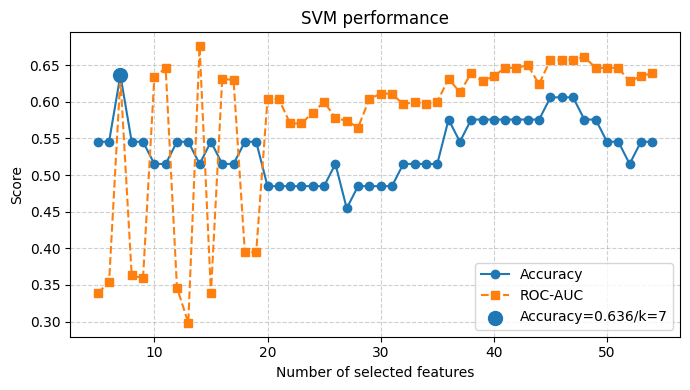


Accuracy = 0.636 | ROC-AUC = 0.633 | k = 7


In [18]:
ranking = kbest_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)



=== Testing top 5 features ===
Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.10353218432956626), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': None, 'C': np.float64(4.150404757850472)}
Accuracy: 0.485 | ROC-AUC: 0.491

=== Testing top 6 features ===
Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.10353218432956626), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': None, 'C': np.float64(4.150404757850472)}
Accuracy: 0.485 | ROC-AUC: 0.489

=== Testing top 7 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(8.286427728546843e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'sigmoid', 'gamma': np.float64(1.5702901247293775), 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(535.3566677410719)}
Accuracy: 0.485 | ROC-AUC: 0.428

=== Testing top 8 features ===
Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.17426333860096507), 'degree': 2, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(58.05225516094895)}
Accuracy: 0.485 | ROC-AUC: 0.459

=== Testing top 9 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.10353218432956626), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': None, 'C': np.float64(4.150404757850472)}
Accuracy: 0.485 | ROC-AUC: 0.515

=== Testing top 10 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(2.0235896477251556e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(1.0473708979594507), 'degree': 4, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(1.5702901247293775)}
Accuracy: 0.485 | ROC-AUC: 0.515

=== Testing top 11 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(6.250551925273976e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(9.437878277775392), 'degree': 5, 'coef0': np.float64(0.35000000000000003), 'class_weight': 'balanced', 'C': np.float64(378.3462617131925)}
Accuracy: 0.485 | ROC-AUC: 0.537

=== Testing top 12 features ===
Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.05170920242896761), 'degree': 3, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(535.3566677410719)}
Accuracy: 0.515 | ROC-AUC: 0.515

=== Testing top 13 features ===
Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.485 | ROC-AUC: 0.544

=== Testing top 14 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.02736439997074672), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(4.150404757850472)}
Accuracy: 0.455 | ROC-AUC: 0.587

=== Testing top 15 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.02736439997074672), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(4.150404757850472)}
Accuracy: 0.455 | ROC-AUC: 0.561

=== Testing top 16 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.02736439997074672), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(4.150404757850472)}
Accuracy: 0.455 | ROC-AUC: 0.591

=== Testing top 17 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.10353218432956626), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': None, 'C': np.float64(4.150404757850472)}
Accuracy: 0.515 | ROC-AUC: 0.594

=== Testing top 18 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.02736439997074672), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(4.150404757850472)}
Accuracy: 0.545 | ROC-AUC: 0.609

=== Testing top 19 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.02736439997074672), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(4.150404757850472)}
Accuracy: 0.545 | ROC-AUC: 0.617

=== Testing top 20 features ===
Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.17426333860096507), 'degree': 2, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(58.05225516094895)}
Accuracy: 0.515 | ROC-AUC: 0.554

=== Testing top 21 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.545 | ROC-AUC: 0.587

=== Testing top 22 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.06517339604882427), 'degree': 5, 'coef0': np.float64(0.30000000000000004), 'class_weight': None, 'C': np.float64(38.27494478516307)}
Accuracy: 0.606 | ROC-AUC: 0.657

=== Testing top 23 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.06517339604882427), 'degree': 5, 'coef0': np.float64(0.30000000000000004), 'class_weight': None, 'C': np.float64(38.27494478516307)}
Accuracy: 0.576 | ROC-AUC: 0.646

=== Testing top 24 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.06517339604882427), 'degree': 5, 'coef0': np.float64(0.30000000000000004), 'class_weight': None, 'C': np.float64(38.27494478516307)}
Accuracy: 0.576 | ROC-AUC: 0.657

=== Testing top 25 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.06517339604882427), 'degree': 5, 'coef0': np.float64(0.30000000000000004), 'class_weight': None, 'C': np.float64(38.27494478516307)}
Accuracy: 0.576 | ROC-AUC: 0.643

=== Testing top 26 features ===
Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.06517339604882427), 'degree': 5, 'coef0': np.float64(0.30000000000000004), 'class_weight': None, 'C': np.float64(38.27494478516307)}
Accuracy: 0.576 | ROC-AUC: 0.628

=== Testing top 27 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.06517339604882427), 'degree': 5, 'coef0': np.float64(0.30000000000000004), 'class_weight': None, 'C': np.float64(38.27494478516307)}
Accuracy: 0.576 | ROC-AUC: 0.628

=== Testing top 28 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.545 | ROC-AUC: 0.617

=== Testing top 29 features ===
Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.545 | ROC-AUC: 0.620

=== Testing top 30 features ===
Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.576 | ROC-AUC: 0.591

=== Testing top 31 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.606 | ROC-AUC: 0.602

=== Testing top 32 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.576 | ROC-AUC: 0.598

=== Testing top 33 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.576 | ROC-AUC: 0.613

=== Testing top 34 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.545 | ROC-AUC: 0.615

=== Testing top 35 features ===
Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.606 | ROC-AUC: 0.641

=== Testing top 36 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.485 | ROC-AUC: 0.567

=== Testing top 37 features ===
Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.485 | ROC-AUC: 0.604

=== Testing top 38 features ===
Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.485 | ROC-AUC: 0.604

=== Testing top 39 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.485 | ROC-AUC: 0.604

=== Testing top 40 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.545 | ROC-AUC: 0.578

=== Testing top 41 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.02899422853882878), 'degree': 5, 'coef0': np.float64(0.7000000000000001), 'class_weight': 'balanced', 'C': np.float64(10.96985797892384)}
Accuracy: 0.636 | ROC-AUC: 0.622

=== Testing top 42 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.515 | ROC-AUC: 0.589

=== Testing top 43 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.515 | ROC-AUC: 0.607

=== Testing top 44 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.545 | ROC-AUC: 0.530

=== Testing top 45 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.515 | ROC-AUC: 0.630

=== Testing top 46 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.515 | ROC-AUC: 0.633

=== Testing top 47 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'sigmoid', 'gamma': np.float64(0.04605922041145108), 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(16.638168860761272)}
Accuracy: 0.515 | ROC-AUC: 0.633

=== Testing top 48 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.485 | ROC-AUC: 0.581

=== Testing top 49 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.485 | ROC-AUC: 0.593

=== Testing top 50 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.515 | ROC-AUC: 0.585

=== Testing top 51 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.515 | ROC-AUC: 0.548

=== Testing top 52 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.485 | ROC-AUC: 0.548

=== Testing top 53 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.485 | ROC-AUC: 0.548

=== Testing top 54 features ===
Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.485 | ROC-AUC: 0.548


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


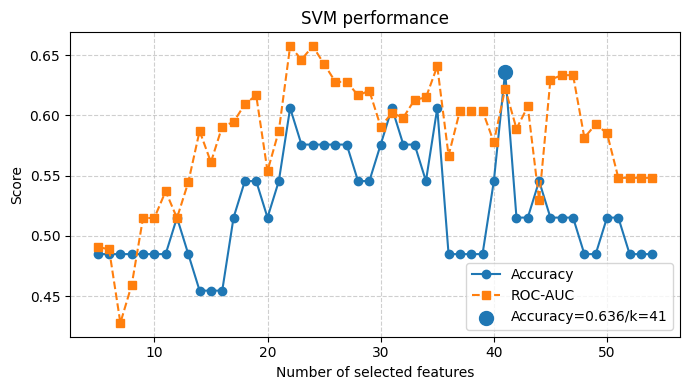


Accuracy = 0.636 | ROC-AUC = 0.622 | k = 41


In [19]:
ranking = lasso_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")